In [ ]:
# | default_exp accurate_spc
%load_ext autoreload
%autoreload 2

# Serial Recall Accuracy Curve

In **serial recall** tasks, participants study a list of items in a specific order and must then recall them **in that same order**. Unlike *free recall* (where recall order is irrelevant), serial recall scoring considers a response correct only if the item is produced in its **original study position**.

The **Serial Recall Accuracy Curve (SRAC)** plots the probability of correctly recalling each list position—specifically, the fraction of trials on which the item studied at position *i* was correctly recalled **in** position *i*.

In [ ]:
# | export

from typing import Optional, Sequence

import jax.numpy as jnp
from jax import jit
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes

from jaxcmr.experimental.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.helpers import apply_by_subject, find_max_list_length
from jaxcmr.typing import Array, Bool, Float, Integer

## Simple Case -- Uniform Lists

When participants study the same list of items on every trial (e.g., always items `1, 2, 3, ...` in the same order), analyzing serial recall accuracy is straightforward.

We start with a 2D array called `recalls`, which stores the recalled items for each trial. Each row of the array is a trial, and each column represents a recall position. For example, `recalls[2, 4]` is the item that a participant recalled in position 4 of trial 2. If a participant doesn't recall anything in a given position, we put a `0`.

In **serial recall** scoring, we mark a recall as correct only if the participant recalled the exact item that appeared in that same position during study. For uniform lists, this simply means checking if the recalled item matches the item's original study position (e.g., at position 1, item `1` is correct; at position 2, item `2` is correct, and so on).

We calculate accuracy for each position by finding out how often participants got that position correct across all trials. This gives us a "serial recall accuracy curve," showing which positions in the list people remember best.

In [ ]:
# | exports


def fixed_pres_srac(
    recalls: Integer[Array, " trial_count recall_positions"], list_length: int
) -> Float[Array, " study_positions"]:
    """
    Returns position-specific recall accuracy, assuming uniform study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        list_length: the number of studied items in each trial.
    """
    return (recalls[:, :list_length] == jnp.arange(1, list_length + 1)).mean(axis=0)

We maintain this specialized implementation for time-sensitive use cases and demonstration purposes.

## Serial Recall Accuracy Curve (Arbitrary or Repeated Lists)

Sometimes participants study different items on each trial, or the same item might appear multiple times within a trial. To handle these cases, we use two arrays:

- `presentations`: Each row corresponds to a trial, and each column indicates which item was presented in each study position.
- `recalls`: Each row corresponds to a trial, and each column shows the item recalled by the participant in each output position.

In serial recall, we mark a recall as correct only if the recalled item matches the exact item presented in the same position during study (`recalls[n, i] == presentations[n, i]`). We then calculate the accuracy at each position by determining how often participants correctly recalled that position across all trials. This gives us the **Serial Recall Accuracy Curve (SRAC)**, showing recall accuracy by position, even when lists differ or contain repetitions.

In [ ]:
# | exports

def srac(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: int,
) -> Float[Array, " study_positions"]:
    """
    Returns position-specific recall accuracy for possibly non-uniform or repeated study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        list_length: the number of studied items in each trial.
    """
    return (recalls[:, :list_length] == presentations[:, :list_length]).mean(axis=0)

## Plotting the Accurate Serial Position Curve

We can use a function analogous to our free recall plotting routine, but here it applies the `srac` or `fixed_pres_srac` under the hood. We'll call `srac` by default.

In [ ]:
# | exports


def plot_srac(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """
    Plots serial recall accuracy curve for one or more datasets.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.

    Returns:
        The matplotlib Axes object containing the plot.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [c["color"] for c in rcParams["axes.prop_cycle"]]

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    if labels is None:
        labels = ["" for _ in datasets]

    # Identify the largest list length across datasets, so we can plot consistently
    max_list_length = find_max_list_length(datasets, trial_masks)

    for data_index, data_dict in enumerate(datasets):
        # We'll apply the accurate_spc function to each subject, then stack
        subject_values = jnp.vstack(
            apply_by_subject(
                data_dict,
                trial_masks[data_index],
                jit(srac, static_argnames=("list_length",)),
            )
        )

        # Plot
        color = color_cycle.pop(0)
        xvals = jnp.arange(max_list_length) + 1
        plot_data(axis, xvals, subject_values, labels[data_index], color)

    set_plot_labels(axis, "Study Position", "Serial Recall Accuracy", contrast_name)
    return axis

## Tests

### Exact Recall (Uniform Lists)

If the list is `[1, 2, 3, 4]` and the participant recalls `[1, 2, 3, 4]` in order, every position is correct.

In [ ]:
# some trivial test
test_recalls = jnp.array([[1, 2, 3, 4], [1, 2, 3, 0]])  # second trial misses 4
list_len = 4
spc_res = fixed_pres_srac(test_recalls, list_len)

assert jnp.allclose(spc_res, jnp.array([1.0, 1.0, 1.0, 0.5]))

### Exact Recall (Arbitrary Lists)

If the `presentations` differ but `recalls` matches them exactly in each position, we get perfect accuracy (1.0) for those positions.

In [ ]:
test_presentations = jnp.array([[10, 11, 12, 13], [10, 99, 12, 13]])
test_recalls = jnp.array([[10, 11, 12, 13], [10, 11, 12, 0]])
spc_res_arb = srac(test_recalls, test_presentations, 4)

assert jnp.allclose(spc_res_arb, jnp.array([1.0, .5, 1.0, 0.5]))

### Handling Longer Recall Arrays

If `recalls` has more positions than the list length, we only consider the first `list_length` columns.

In [ ]:
test_recalls_extra = jnp.array([[1, 2, 3, 4, 99, 99], [1, 2, 3, 0, 42, 42]])
spc_res_extra = fixed_pres_srac(test_recalls_extra, 4)
assert jnp.allclose(spc_res_extra, jnp.array([1.0, 1.0, 1.0, 0.5]))

## Examples

With real data, we would typically have a dictionary containing:
- `recalls`: a [trials x possibly_many_output_positions] array
- `pres_itemnos`: a [trials x list_length] array

Then we can use the provided plotting function to visualize position-wise accuracy for different conditions.

In [ ]:
from jaxcmr.helpers import generate_trial_mask, load_data, find_project_root
import os

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Array([0.21666667, 0.16428572, 0.10476191, 0.07380953, 0.04761905,
       0.0452381 , 0.02857143, 0.02142857, 0.03095238, 0.02380952,
       0.02380952, 0.01904762, 0.01428572, 0.01190476, 0.01428572,
       0.01428572, 0.01190476, 0.00714286, 0.0047619 , 0.00238095,
       0.00952381, 0.0047619 , 0.00238095, 0.00714286, 0.        ,
       0.00238095, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float32)

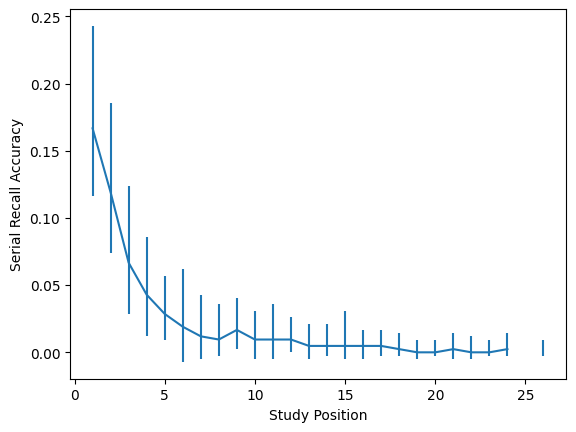

In [ ]:
# parameters
run_tag = "SRAC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path =  os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_srac(data, generate_trial_mask(data, data_query))
jit(srac, static_argnames=("list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)